In [1]:
from helper_code import *
import numpy as np, os, sys, joblib
import ecg_plot
import pandas as pd
from glob import glob
import os
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from tsai.all import *
import torch
import optuna
from optuna.integration import FastAIPruningCallback
from sklearn.metrics import classification_report
import transformation_funcs as tfs
import seaborn as sns
from torchsummary import summary
torch.cuda.set_device(2) 

In [85]:
def snomedConvert(label_df,snomed=True):
    codes =  pd.concat([pd.read_csv("data/codes.csv",sep=",")[["Dx","SNOMEDCTCode"]],pd.read_csv("data/codes_2.csv",sep=",")[["Dx","SNOMEDCTCode"]]])

    if snomed:
        label_df.columns = [codes[codes["SNOMEDCTCode"] == int(x)]["Dx"].item() for x in label_df.columns]
        return label_df
DATASET_NAME = "WFDB_CPSC2018_signitured"
# DATASET_NAME = "WFDB_ChapmanShaoxing"

X = np.load('./data/big_numpy_datasets/%s.npy'%DATASET_NAME, mmap_mode='c')
label_df = pd.read_csv("data/%s.csv"%DATASET_NAME).drop(columns=["headers","leads"])
y = snomedConvert(label_df)
X.shape

ValueError: can only convert an array of size 1 to a Python scalar

In [77]:
codes =  pd.concat([pd.read_csv("data/codes.csv",sep=",")[["Dx","SNOMEDCTCode"]],pd.read_csv("data/codes_2.csv",sep=",")[["Dx","SNOMEDCTCode"]]])
# codes.drop_duplicates(subset="Dx")
# codes.to_csv("data/snomed_codes.csv",index=False)

In [83]:
codes =  pd.concat([pd.read_csv("data/codes.csv",sep=",")[["Dx","SNOMEDCTCode"]],pd.read_csv("data/codes_2.csv",sep=",")[["Dx","SNOMEDCTCode"]]])

for l in label_df.columns:
    string_label = codes[codes["SNOMEDCTCode"]==int(l)]
    if len(string_label):
        print(string_label["Dx"].iloc[0])
        
    else:
        print(l)

,Dx,SNOMEDCTCode
0,2nd degree av block,195042002
1,abnormal QRS,164951009
2,accelerated junctional rhythm,426664006
3,acute myocardial infarction,57054005
4,acute myocardial ischemia,413444003
...,...,...
98,paired ventricular premature complexes,251182009
99,ventricular tachycardia,164895002
100,ventricular trigeminy,251180001
101,wandering atrial pacemaker,195101003


'ventricular bigeminy'

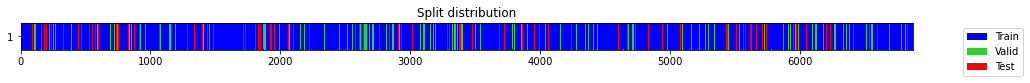

Counts by label: {'right bundle branch block': 1857, 'sinus rhythm': 918, 'atrial fibrillation': 1221, 'ventricular ectopics': 700, 'st depression': 869, 'left bundle branch block': 236, 'st elevation': 220, '1st degree av block': 722, 'premature atrial contraction': 616}


In [48]:

cv_splits = get_splits(y.to_numpy(), valid_size=.1,test_size=0.1, stratify=False, random_state=23, shuffle=True)
y_multi = []
for i,row in y.iterrows():
    sample_labels = []
    for i,r in enumerate(row):
        if r == True:
            sample_labels.append(y.columns[i])
        
    y_multi.append(list(tuple(sample_labels)))
label_counts = collections.Counter([a for r in y_multi for a in r])
print('Counts by label:', dict(label_counts))

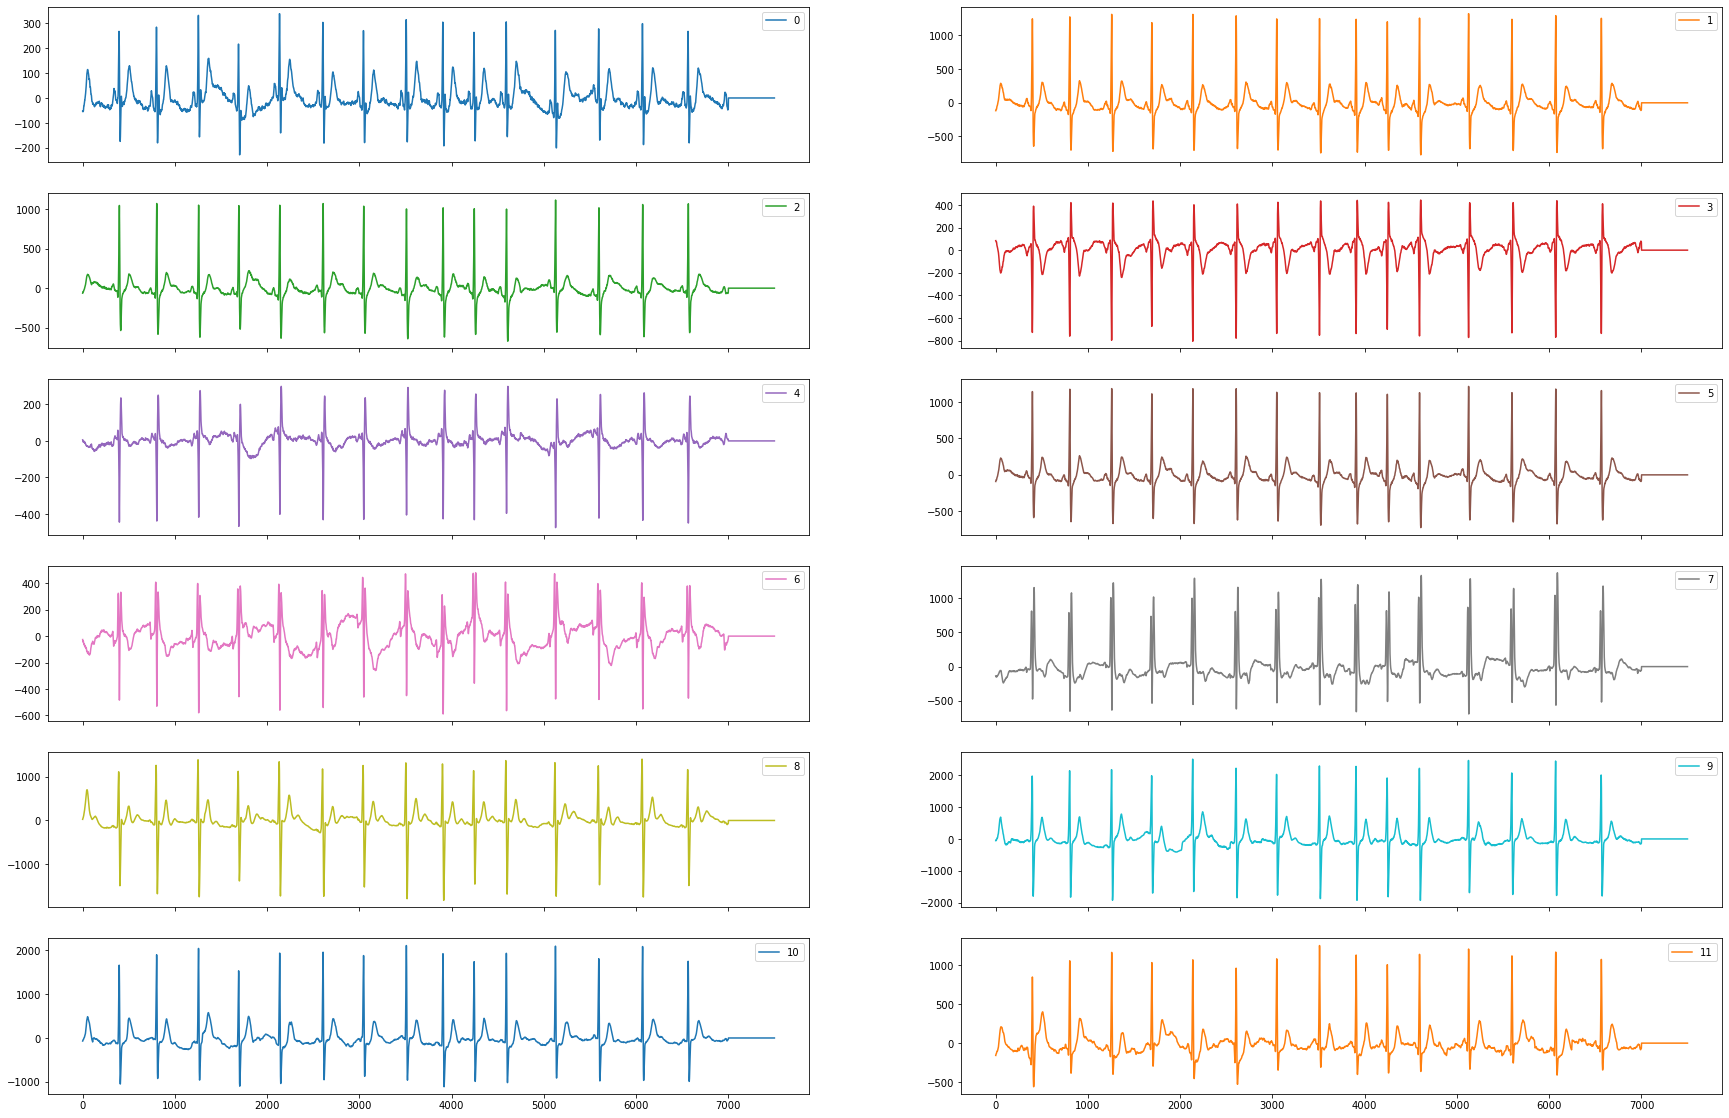

In [49]:
fig = pd.DataFrame(X[5]).T.plot.line(subplots = True,layout=(6,2), figsize=(30,20))

epoch,train_loss,valid_loss,accuracy_multi,balanced_accuracy_multi,precision_multi,recall_multi,specificity_multi,F1_multi,time
0,0.264609,0.214225,0.923823,0.713219,0.864057,0.435994,0.990445,0.578273,00:13
1,0.214371,0.208563,0.923338,0.760465,0.745751,0.546113,0.974816,0.629984,00:13
2,0.186455,0.173778,0.935630,0.791200,0.812354,0.601143,0.981257,0.690571,00:13
3,0.165207,0.157914,0.941938,0.812662,0.834017,0.642599,0.982726,0.725468,00:14
4,0.152514,0.144264,0.949054,0.836882,0.859050,0.689206,0.984557,0.764472,00:14
5,0.149052,0.143021,0.947275,0.834934,0.843622,0.687139,0.982728,0.757029,00:14
6,0.139106,0.135211,0.952774,0.848663,0.870890,0.711655,0.985671,0.782956,00:14
7,0.134228,0.139678,0.951642,0.844315,0.867352,0.703144,0.985485,0.776434,00:14
8,0.129858,0.126882,0.956008,0.855102,0.888621,0.722330,0.987874,0.796455,00:14
9,0.130383,0.146051,0.948569,0.833001,0.861424,0.680889,0.985114,0.760549,00:14


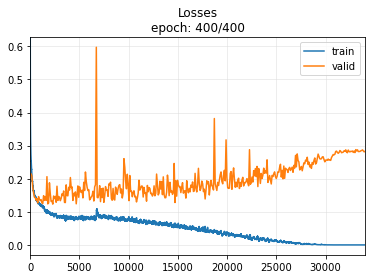

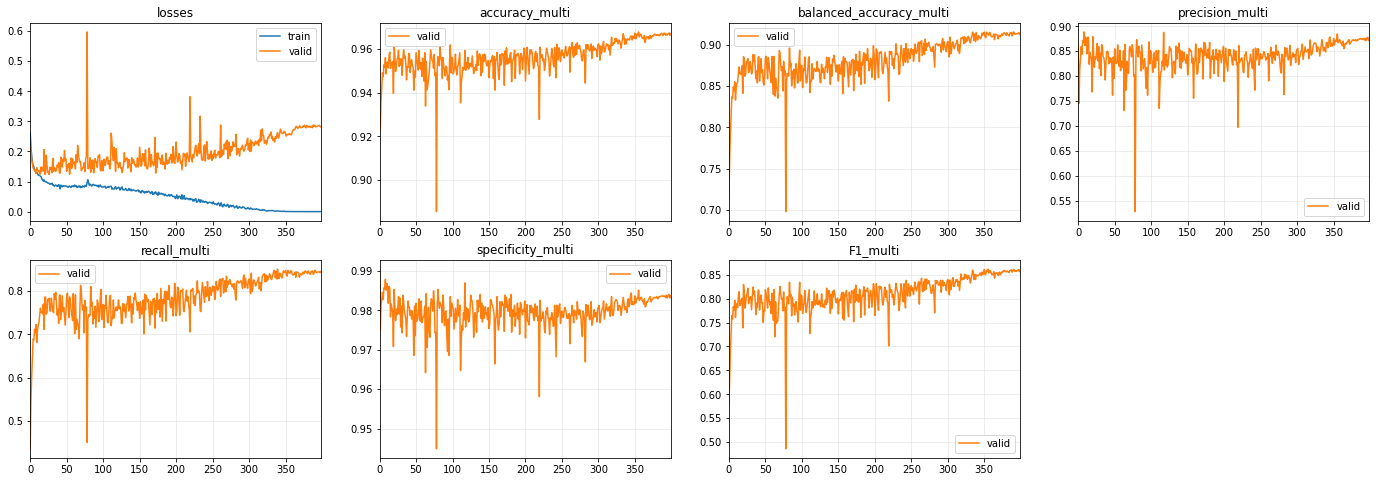

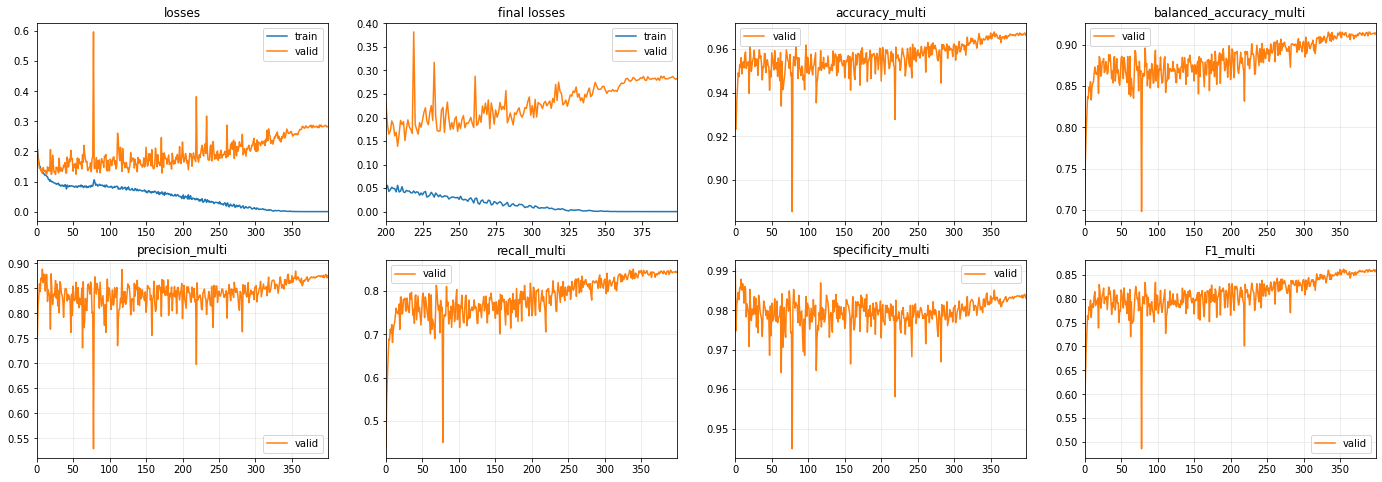

In [61]:
max_len = 5000
sf = 0.3
tfms  = [None, TSMultiLabelClassification()]
batch_tfms = [
#              TSStandardize(by_sample=True),
                tfs.Normalize(),
                tfs.Scale(scale_factor=sf,),
                tfs.BandPass(int(sf*500),low_cut=60, high_cut=1,leads=12,),
#               tfs.RandomShift(0.1),
#               tfs.MulNoise(6),
#               tfs.CutOutWhenTraining(),
             ]

dsets = TSDatasets(X.astype(float)[:,:,0:max_len], y_multi, tfms=tfms, splits=cv_splits) # inplace=True by default
dls   = TSDataLoaders.from_dsets(dsets.train,dsets.valid, bs=[64, 128], batch_tfms=batch_tfms, num_workers=0)
metrics =[accuracy_multi, balanced_accuracy_multi, precision_multi, recall_multi, specificity_multi, F1_multi] 
#     model = MiniRocketPlus(dls.vars, dls.c,dls.len)
model = InceptionTimePlus(dls.vars, dls.c, dls.len, depth=10,ks = 100 )
#     model = XceptionTimePlus(dls.vars, dls.c)
#     model = MultiTSTPlus(dls.vars, dls.c,int(sf*2500),max_seq_len=200,attn_dropout=0.5,dropout=0.3)

#     learn = Learner(dls, model, metrics=metrics,loss_func = BCEWithLogitsLossFlat(pos_weight=dls.train.cws.sqrt()),cbs=[ShowGraph()],)
learn = Learner(dls,model, metrics=metrics,cbs=[ShowGraph()])
learn.fit_one_cycle(400, lr_max=1e-1)
learn.recorder.plot_metrics()

In [ ]:
import torchaudio
torchaudio.__version__,torch.__version__,tsai.__version__


In [ ]:
#     model = MiniRocketPlus(dls.vars, dls.c,dls.len)
model = InceptionTimePlus(dls.vars, dls.c, dls.len, depth=8,)
#     model = XceptionTimePlus(dls.vars, dls.c)
#     model = MultiTSTPlus(dls.vars, dls.c,500,)

learn = Learner(dls, model, metrics=metrics,loss_func = BCEWithLogitsLossFlat(pos_weight=dls.train.cws.sqrt()),cbs=[ShowGraph()],)
#     learn = Learner(dls,model, metrics=metrics,cbs=[ShowGraph()],)

In [62]:
tfms  = [None, TSMultiLabelClassification()]
batch_tfms = [
#              TSStandardize(by_sample=True),
                tfs.Normalize(),
                tfs.Scale(scale_factor=sf,),
                tfs.BandPass(int(sf*500),low_cut=60, high_cut=1,leads=12,),
#               tfs.RandomShift(0.1),
#               tfs.MulNoise(6),
#               tfs.CutOutWhenTraining(),
             ]
reports = []
# for cv_num in range(1):
fold_splits = cv_splits
dsets = TSDatasets(X.astype(float), y_multi, tfms=tfms, splits=(fold_splits[0],fold_splits[2])) # inplace=True by default
dls   = TSDataLoaders.from_dsets(dsets.train,dsets.valid, bs=[128, 128], batch_tfms=batch_tfms, num_workers=0)
# model = InceptionTimePlus(dls.vars, dls.c, dls.len, depth=8,)
#     learn = Learner(dls, model, metrics=metrics, 
#                     cbs=[ShowGraph()],)
#     learn.load("inception_augmented_%s"%cv_num)
valid_probas, valid_targets, valid_preds = learn.get_preds(dl=dls.valid, with_decoded=True)

y_pred = (valid_preds>0)
y_test = valid_targets

report = classification_report(y_test, y_pred,target_names = dls.vocab.o2i.keys(),digits=3,output_dict=True)
reports.append(report)
for report in reports:
    for k,v in report.items():
        report[k] = report[k]["f1-score"]
df = pd.DataFrame(reports).median()
df

1st degree av block             0.845528
atrial fibrillation             0.917355
left bundle branch block        0.923077
premature atrial contraction    0.636364
right bundle branch block       0.938776
sinus rhythm                    0.644737
st depression                   0.787879
st elevation                    0.432432
ventricular ectopics            0.792208
micro avg                       0.824611
macro avg                       0.768706
weighted avg                    0.816673
samples avg                     0.765163
dtype: float64